In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
import scikitplot as skplt
import datetime
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from datetime import timedelta

## Preprocessing and Exploratory Analysis

### 1. Understand the data
Drop columns "Id", "Name", "City", "Zip" as these columns contains mostly unique values, hence is not useful for our prediction. 

Column "BalanceGross" also need to be dropped as the whole column is $0.00.  

By inspecting the dtypes of each column, we noted that some of the features are not numerical hence need to apply some formatting. The following method is applied:

* **State** - Will be handled during the feature engineering
* **Bank** - Will be handled during the feature engineering
* **BankState** - Will be handled during the feature engineering
* **ApprovalFY** - Replace the "1976A" with "1976" and convert to int format
* **ApprovalDate and DisbursementDate** - Convert to datetime format
* **DisbursementGross, GrAppv and SBA_Appv** - Remove the $ sign and convert to float format
* **RevlineCr, NewExist, LowDoc** - Remove all the invalid values that not specified in the dataset info


In [2]:
df = pd.read_csv('Xtrain.csv', dtype={"ApprovalFY": object})
df_y = pd.read_csv('Ytrain.csv')
df = pd.concat([df, df_y['ChargeOff']], axis=1, sort=False)
df = df.drop(['Id', 'Name', 'City', 'Zip', 'BalanceGross'], axis= 1)
df.dtypes

State                 object
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
GrAppv                object
SBA_Appv              object
ChargeOff              int64
dtype: object

In [3]:
df['ApprovalFY'] = df['ApprovalFY'].replace('1976A', 1976)
df['ApprovalFY'] = df['ApprovalFY'].astype(int)
df[['ApprovalDate', 'DisbursementDate']] = df[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)
currency_cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
df[currency_cols] = df[currency_cols].replace('[$,]', '', regex=True).astype(float)
df['LowDoc'] = np.where((df['LowDoc'] == "N") | (df['LowDoc'] == "Y"), df['LowDoc'], np.nan)
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y': 1})
df['NewExist'] = np.where((df['NewExist'] == 2) | (df['NewExist'] == 1), df['NewExist'], np.nan)
df['NewExist'] = df['NewExist'].replace({2: 1, 1: 0})
df['RevLineCr'] = np.where((df['RevLineCr'] == "N") | (df['RevLineCr'] == "Y"), df['RevLineCr'], np.nan)
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})

After converting the features to the supported format, it was noted that some of the features also contains missing values. The following method is used to handle the missing values:

* **Bank** - Will be handled during the feature engineering
* **BankState** - Will be handled during the feature engineering
* **NewExist** - Fill the missing value with the most frequent value in the column
* **RevLineCr** - Fill the missing value with the most frequent value in the column
* **LowDoc** - Can be inferred from the "DisbursementGross" column. If the amount is more than 150000 then it is not a low doc loan.  (https://www.sba7a.loans/sba-7a-loans-small-business-blog/low-doc-sba-loans)
* **DisbursementDate** - Can be inferred from the "ApprovalDate" column. We can use the average days from the approval date to the disbursement date to fill all the missing values.


In [4]:
df.isnull().sum()

State                    0
Bank                    76
BankState               77
NAICS                    0
ApprovalDate             0
ApprovalFY               0
Term                     0
NoEmp                    0
NewExist                36
CreateJob                0
RetainedJob              0
FranchiseCode            0
UrbanRural               0
RevLineCr            14993
LowDoc                 352
DisbursementDate       119
DisbursementGross        0
GrAppv                   0
SBA_Appv                 0
ChargeOff                0
dtype: int64

In [4]:
df['RevLineCr'] = np.where(df['RevLineCr'].isnull(), df['RevLineCr'].mode(), df['RevLineCr'])
df['NewExist'] = np.where(df['NewExist'].isnull(), df['NewExist'].mode(), df['NewExist'])
df['LowDoc'] = np.where((df['LowDoc'].isnull()) & (df['DisbursementGross'] < 150000), 1, df['LowDoc'])
df['LowDoc'] = np.where((df['LowDoc'].isnull()) & (df['DisbursementGross'] >= 150000), 0, df['LowDoc'])

df_temp = df.copy().dropna()
df_temp['Appv_to_Disb_Days'] = df_temp['DisbursementDate'] - df_temp['ApprovalDate']
df_temp['Appv_to_Disb_Days'] = df_temp['Appv_to_Disb_Days'].astype('str').apply(lambda day: day[:day.index('d') - 1]).astype('int64')
print("Average days from Approval Date to Disbuesement Date: {} days".format(df_temp['Appv_to_Disb_Days'].mean()))
df['DisbursementDate'] = np.where(df['DisbursementDate'].isnull(), df['ApprovalDate'] + timedelta(days=94), df['DisbursementDate'])

Average days from Approval Date to Disbuesement Date: 94.35746551827982 days


In [6]:
df_temp['Appv_to_Disb_Days'].describe()

count    49809.000000
mean        94.357466
std        159.301187
min       -357.000000
25%         26.000000
50%         47.000000
75%         97.000000
max       3616.000000
Name: Appv_to_Disb_Days, dtype: float64

### 2. Exploratory Data Analysis and Feature Engineering  

**NAICS Column** 

Although the feature "NAICS" is numerical value, these values are not relate to each other. E.g., The value 722110 is larger than 423120, but it does not mean the industry with 722110 is guarenteed better/worse than 423120. Hence, it would make more sense to compare the default rate of different industries. 

In order to do so, we calculated the default rate for each industry and replace the NAICS code with these values.  

Note: the first two digit of the NAICS code represents the industry: (https://www.naics.com/search/)

In [5]:
df["NAICS"] = df["NAICS"].apply(lambda x: x // 10000)
industry_default = df.groupby(['NAICS','ChargeOff'])['NAICS'].count().unstack('ChargeOff')
industry_default['# of Loans Taken'] = industry_default[1] + industry_default[0]
industry_default['Default Rate'] = round(industry_default[0]/(industry_default[1] + industry_default[0]), 2)
industry_default = industry_default.sort_values(by='Default Rate')
default_rate_by_industry = industry_default.to_dict()["Default Rate"]
df['Def_Rate_Industry'] = df['NAICS'].replace(default_rate_by_industry)
# pprint(default_rate_by_industry)
industry_default.head()

ChargeOff,0,1,# of Loans Taken,Default Rate
NAICS,,,,
92,4,8,12,0.33
53,326,656,982,0.33
52,227,439,666,0.34
61,164,271,435,0.38
49,58,96,154,0.38


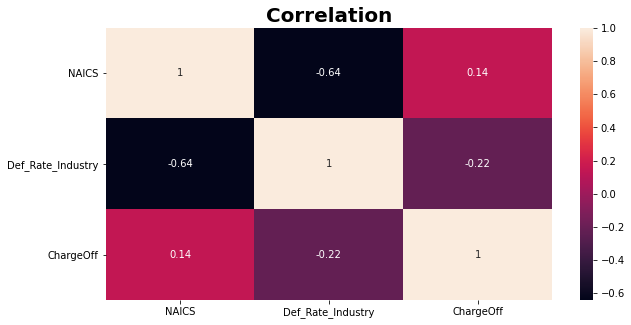

In [8]:
f, ax = plt.subplots(figsize=(10,5))
sb.heatmap(df[["NAICS", "Def_Rate_Industry", "ChargeOff"]].corr(), annot=True)
ax.set_title('Correlation',fontweight="bold", size=20)
plt.show()

**State, Bank and BankState Columns**

* Similar to NAICS code, we can also calcuate the default rate of each state.
Note: There are some missing value in the test data set for the "State" feature, we will use the average state default rate to fill these columns.
* Besides, we also tried to add a new feature: Bank_Same_State, which specifies whether the company is in the same state as the bank state. 
* For the Bank and BankState feature, we will replace the string value with a corresponding integer value.

We noted that the correlation between the newly created features all has a good correlation with "ChargeOff".

In [6]:
df['Bank_Same_State'] = np.where(df['State'] == df['BankState'], 1, 0)
state_default = df.groupby(['State','ChargeOff'])['State'].count().unstack('ChargeOff')
state_default['# of Loans Taken'] = state_default[1] + state_default[0]
state_default['Default Rate'] = round(state_default[0]/(state_default[1] + state_default[0]), 2)
state_default = state_default.sort_values(by='Default Rate')
mean_rate = state_default['Default Rate'].mean()
default_rate_by_state = state_default.to_dict()["Default Rate"]
df['Def_Rate_State'] = df['State'].replace(default_rate_by_state)
df['Def_Rate_State'] = np.where(df['Def_Rate_State'].isnull(), 0.54, df['Def_Rate_State'])
banks = {v: k for k, v in enumerate(list(df['Bank'].unique()))}
df['Bank'].replace(banks, inplace=True)
bank_states = {v: k for k, v in enumerate(list(df['BankState'].unique()))}
df['BankState'].replace(bank_states, inplace=True)

print(default_rate_by_state)
print("Mean State Default Rate: {}".format(mean_rate))
state_default.head()

{'FL': 0.36, 'TN': 0.41, 'GA': 0.41, 'SC': 0.42, 'AZ': 0.42, 'MI': 0.42, 'NV': 0.43, 'IL': 0.43, 'KY': 0.45, 'MD': 0.45, 'NY': 0.46, 'DC': 0.46, 'NJ': 0.47, 'UT': 0.48, 'CO': 0.48, 'TX': 0.48, 'CA': 0.49, 'VA': 0.49, 'IN': 0.5, 'LA': 0.5, 'NC': 0.5, 'OH': 0.51, 'AR': 0.51, 'OK': 0.52, 'DE': 0.52, 'HI': 0.53, 'MO': 0.54, 'MS': 0.54, 'AL': 0.55, 'OR': 0.55, 'PA': 0.56, 'WA': 0.56, 'WV': 0.56, 'KS': 0.58, 'ID': 0.58, 'AK': 0.59, 'MA': 0.59, 'CT': 0.59, 'WI': 0.6, 'MN': 0.61, 'NE': 0.62, 'RI': 0.63, 'NM': 0.63, 'IA': 0.65, 'NH': 0.66, 'MT': 0.72, 'ME': 0.72, 'VT': 0.73, 'SD': 0.75, 'WY': 0.76, 'ND': 0.77}
Mean State Default Rate: 0.543921568627451


ChargeOff,0,1,# of Loans Taken,Default Rate
State,,,,
FL,997,1768,2765,0.36
TN,235,336,571,0.41
GA,610,872,1482,0.41
SC,137,191,328,0.42
AZ,460,627,1087,0.42


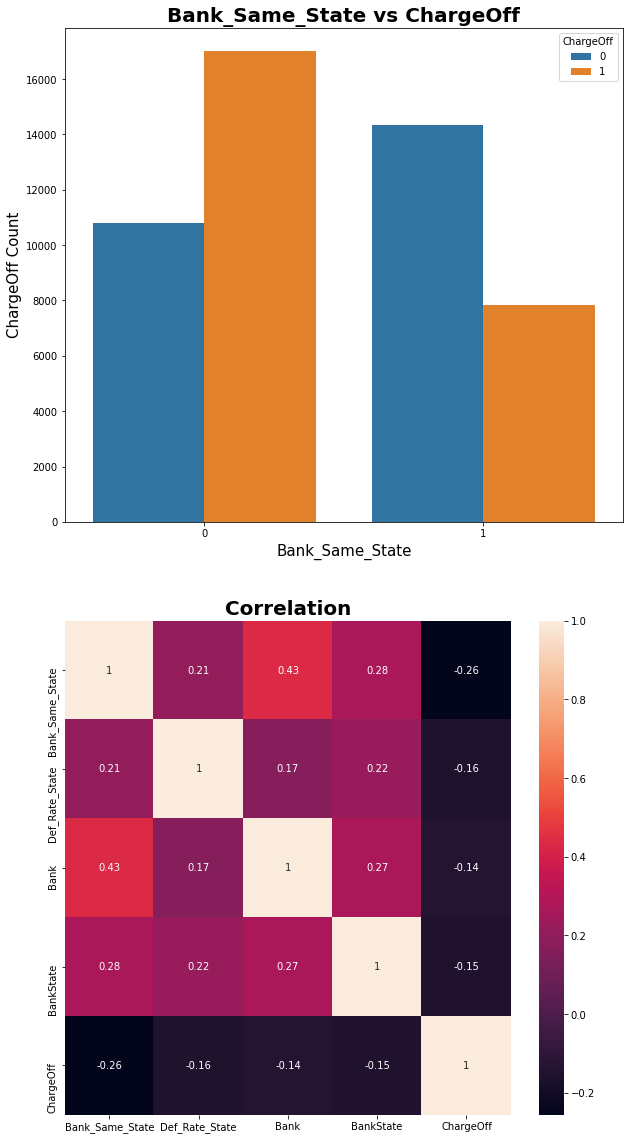

In [10]:
f, axes = plt.subplots(2, figsize=(10,20))
sb.countplot(x="Bank_Same_State", data=df, hue='ChargeOff', ax=axes[0])
sb.heatmap(df[["Bank_Same_State", "Def_Rate_State", "Bank", "BankState", "ChargeOff"]].corr(), annot=True, ax=axes[1])

axes[0].set_title('Bank_Same_State vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize=15)
axes[0].set_xlabel('Bank_Same_State', fontsize=15)
axes[1].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**Date columns**

During online research, it was noted that the time from 2007 to 2009 is known as the Greate Recession. During this time period, it was observed that the number of loans taken during this period is increased greatly, as well as the default rate (refer to the plot below), which is reasonable becasue the economy is bad. 

In [7]:

df['DisbursementFY'] = df['DisbursementDate'].map(lambda x: x.year).astype(int)
df['GreatRecession'] = np.where(((2007 <= df['DisbursementFY']) & (df['DisbursementFY'] <= 2009)) | 
                                     ((df['DisbursementFY'] < 2007) & (df['DisbursementFY'] + (df['Term']/12) >= 2007)), 1, 0)

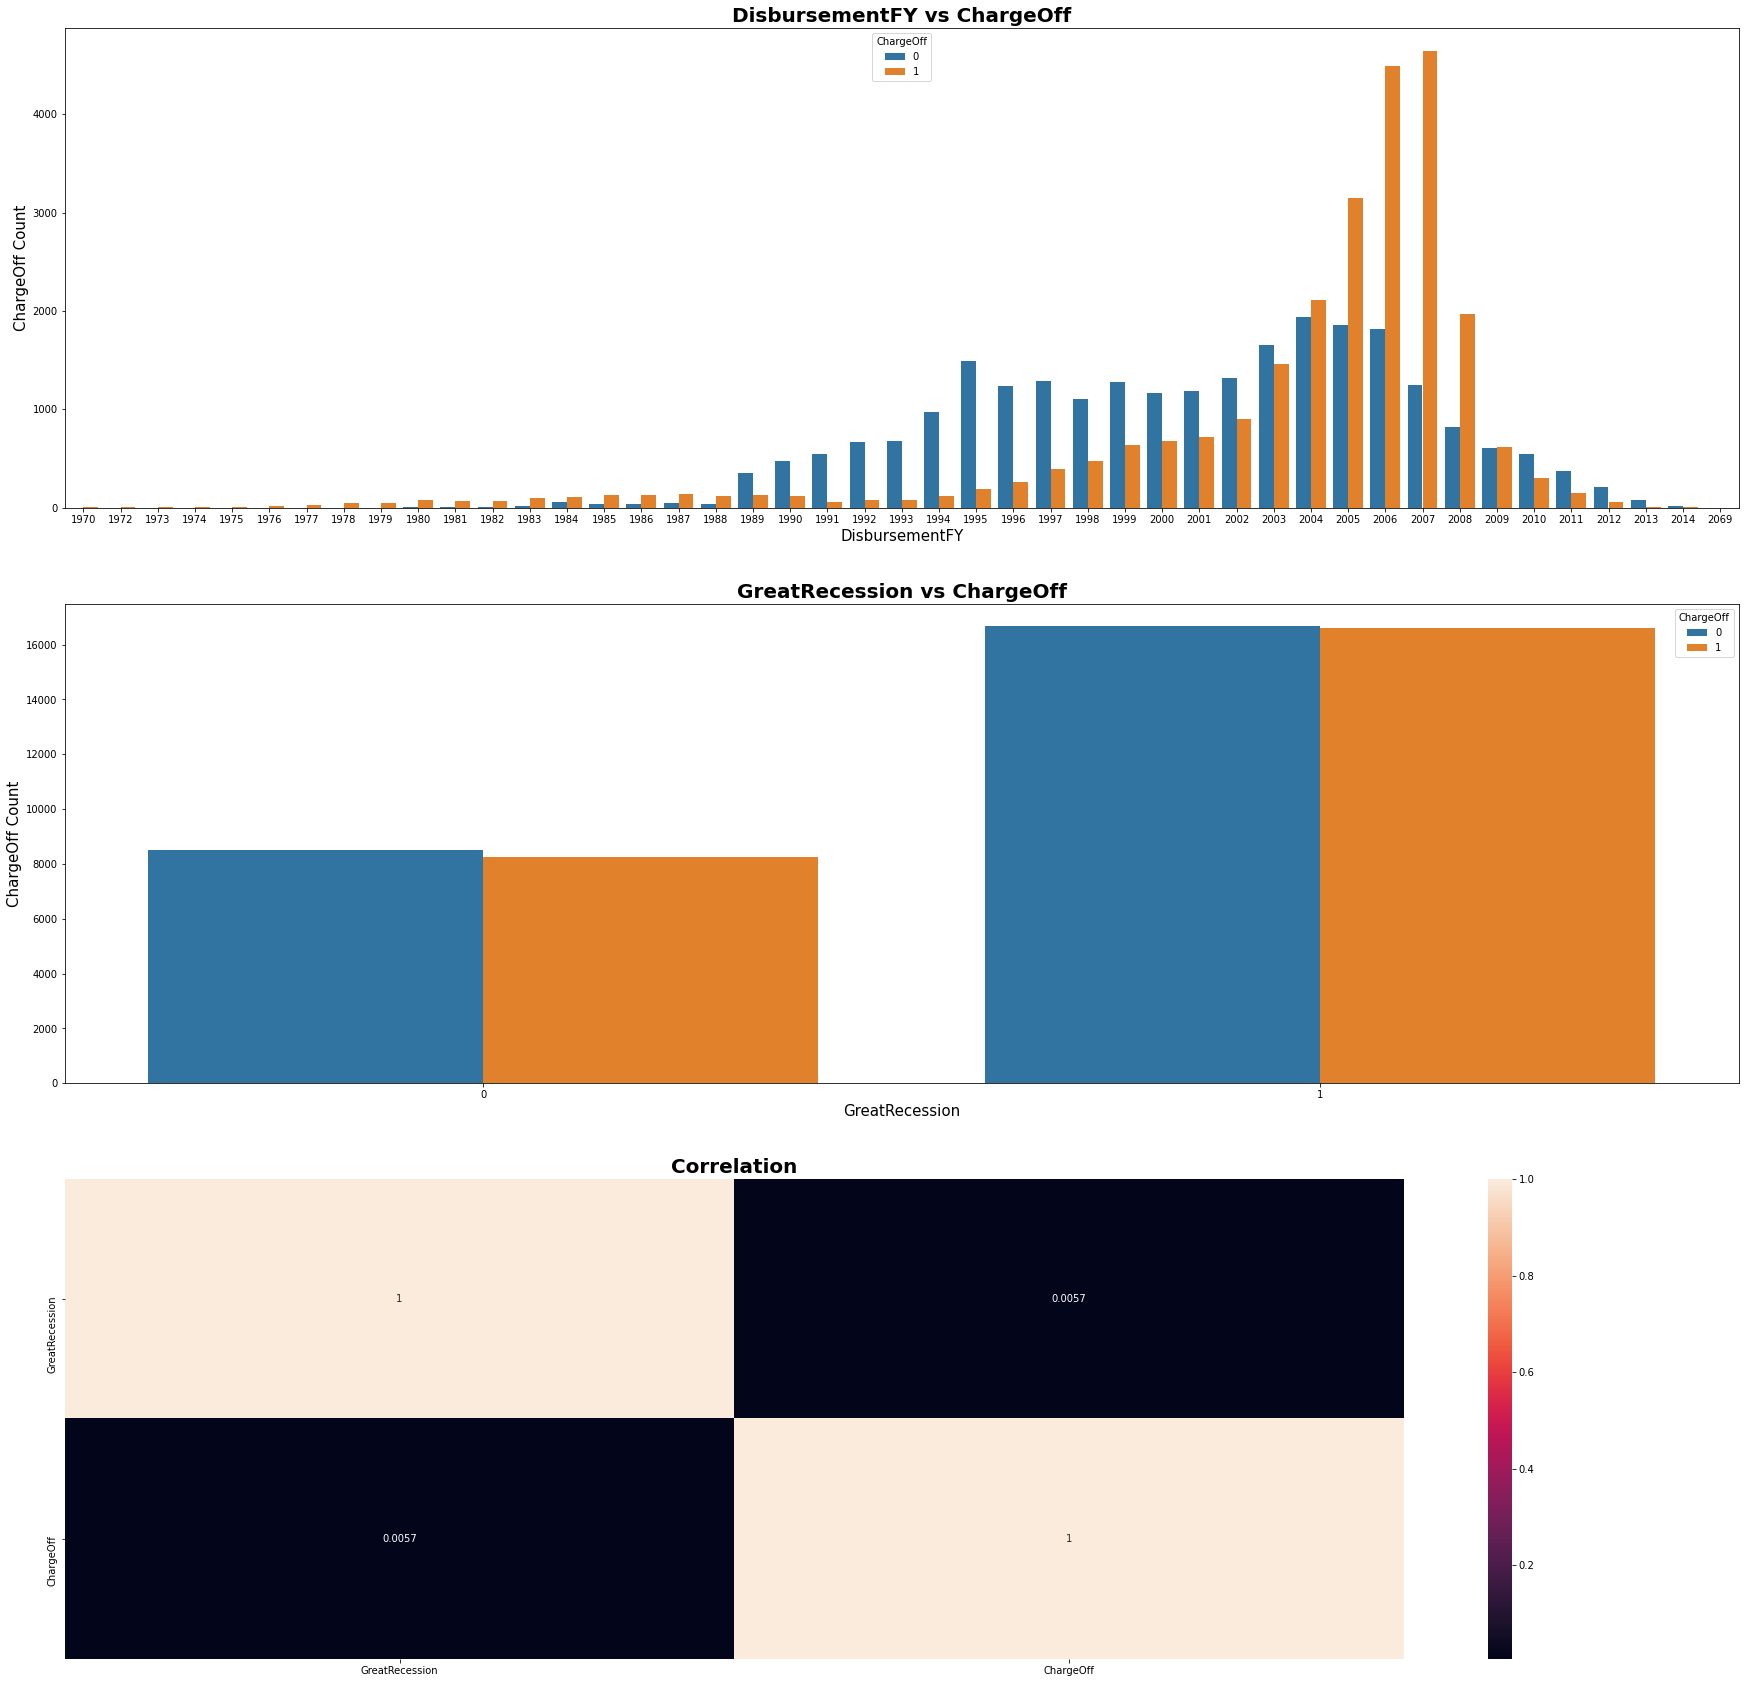

In [12]:
f, axes = plt.subplots(3, figsize=(30,30))
sb.countplot(x="DisbursementFY", data = df, hue = 'ChargeOff', ax=axes[0])
sb.countplot(x="GreatRecession", data = df, hue = 'ChargeOff', ax=axes[1])
sb.heatmap(df[["GreatRecession", "ChargeOff"]].corr(), annot=True, ax=axes[2])

axes[0].set_title('DisbursementFY vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('DisbursementFY', fontsize = 15)
axes[1].set_title('GreatRecession vs ChargeOff',fontweight="bold", size=20)
axes[1].set_ylabel('ChargeOff Count', fontsize = 15)
axes[1].set_xlabel('GreatRecession', fontsize = 15)
axes[2].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**CreateJob Column**  

From the plot below, it was noted that when 0 job is create, the loan is more likely to be paid off, hence this column can be categorized with the following rules:

* 0 (No Job Created): 0
* 1 (Jobs Created): more than 0

Noted there is a significant improve in the correlation

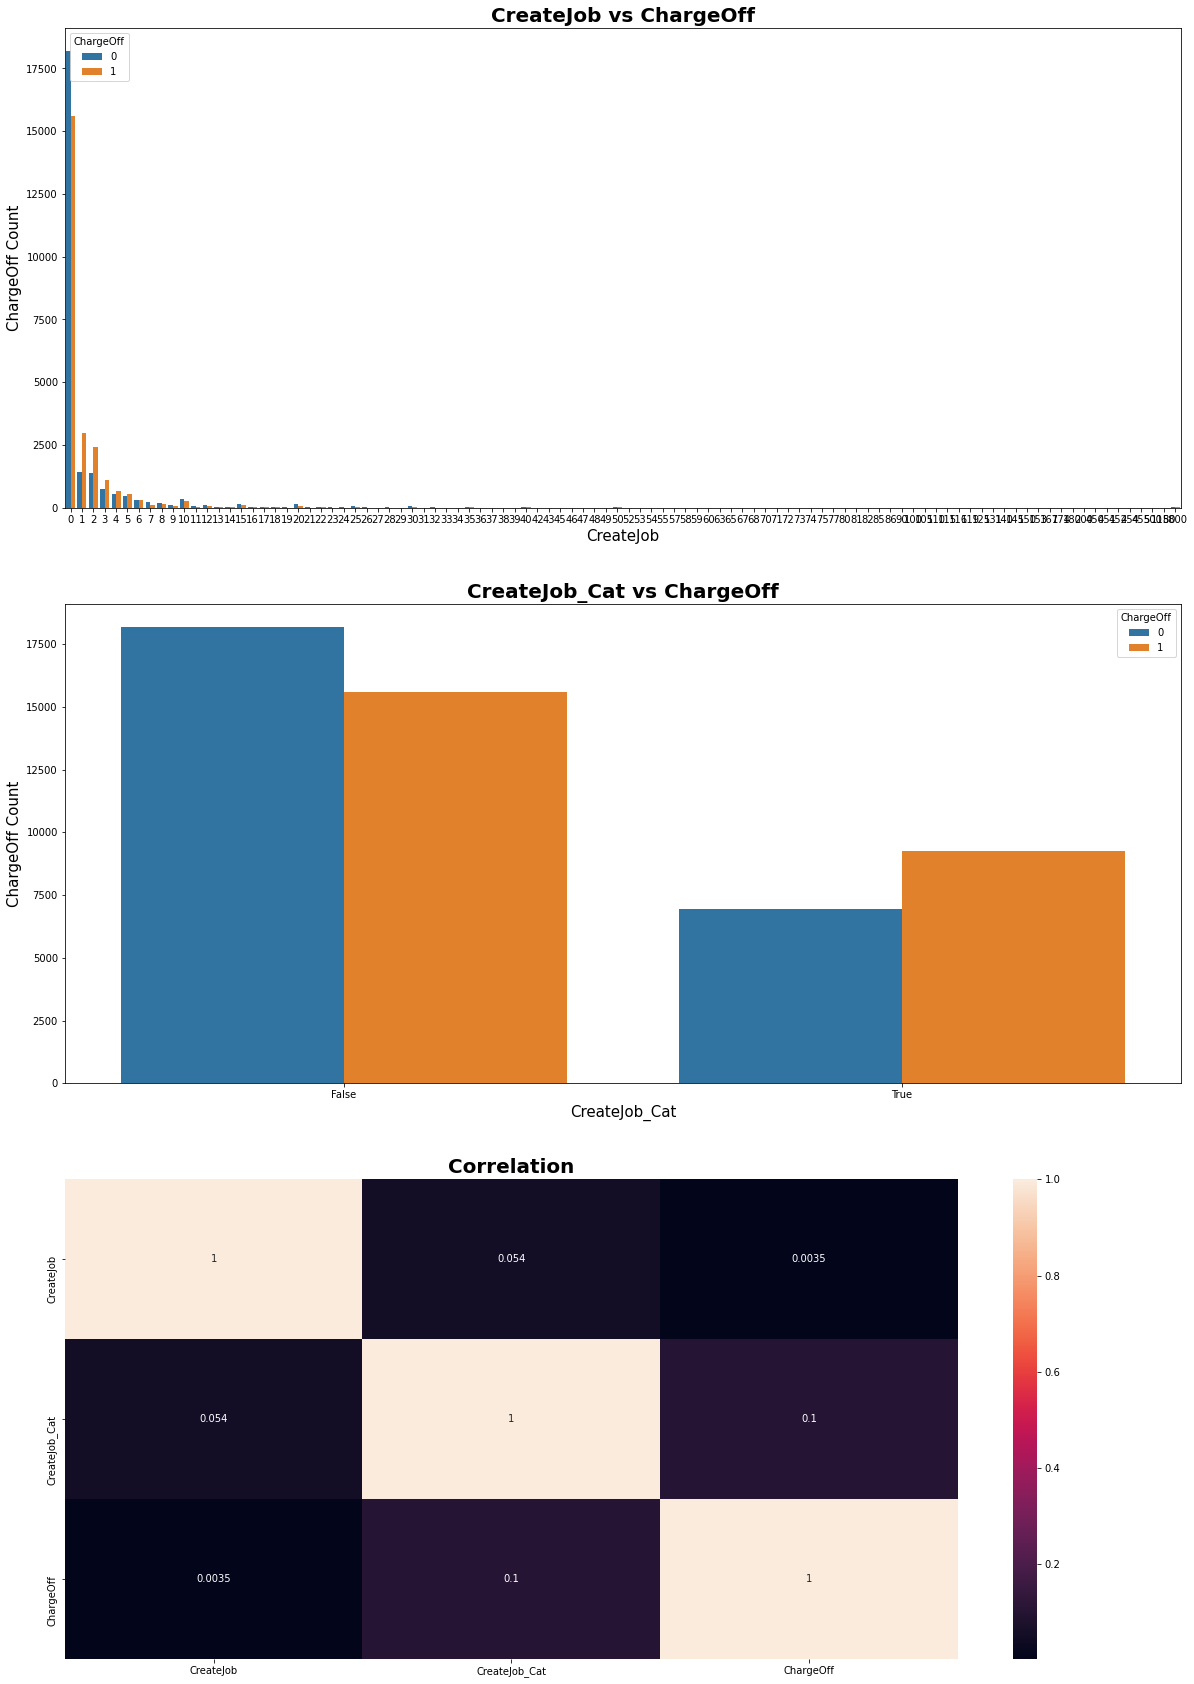

In [8]:
f, axes = plt.subplots(3, figsize=(20,30))
sb.countplot(x="CreateJob", data = df, hue = 'ChargeOff', ax=axes[0])
df["CreateJob_Cat"] = df["CreateJob"].apply(lambda x: x != 0)
sb.countplot(x="CreateJob_Cat", data = df, hue = 'ChargeOff', ax=axes[1])
sb.heatmap(df[["CreateJob", "CreateJob_Cat", "ChargeOff"]].corr(), annot=True, ax=axes[2])

axes[0].set_title('CreateJob vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('CreateJob', fontsize = 15)
axes[1].set_title('CreateJob_Cat vs ChargeOff',fontweight="bold", size=20)
axes[1].set_ylabel('ChargeOff Count', fontsize = 15)
axes[1].set_xlabel('CreateJob_Cat', fontsize = 15)
axes[2].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**RetainedJob Column**  

From the plot below, we noted the similar pattern as CreateJob, hence we can use the same approach to split the RetainedJob column in to two categories.

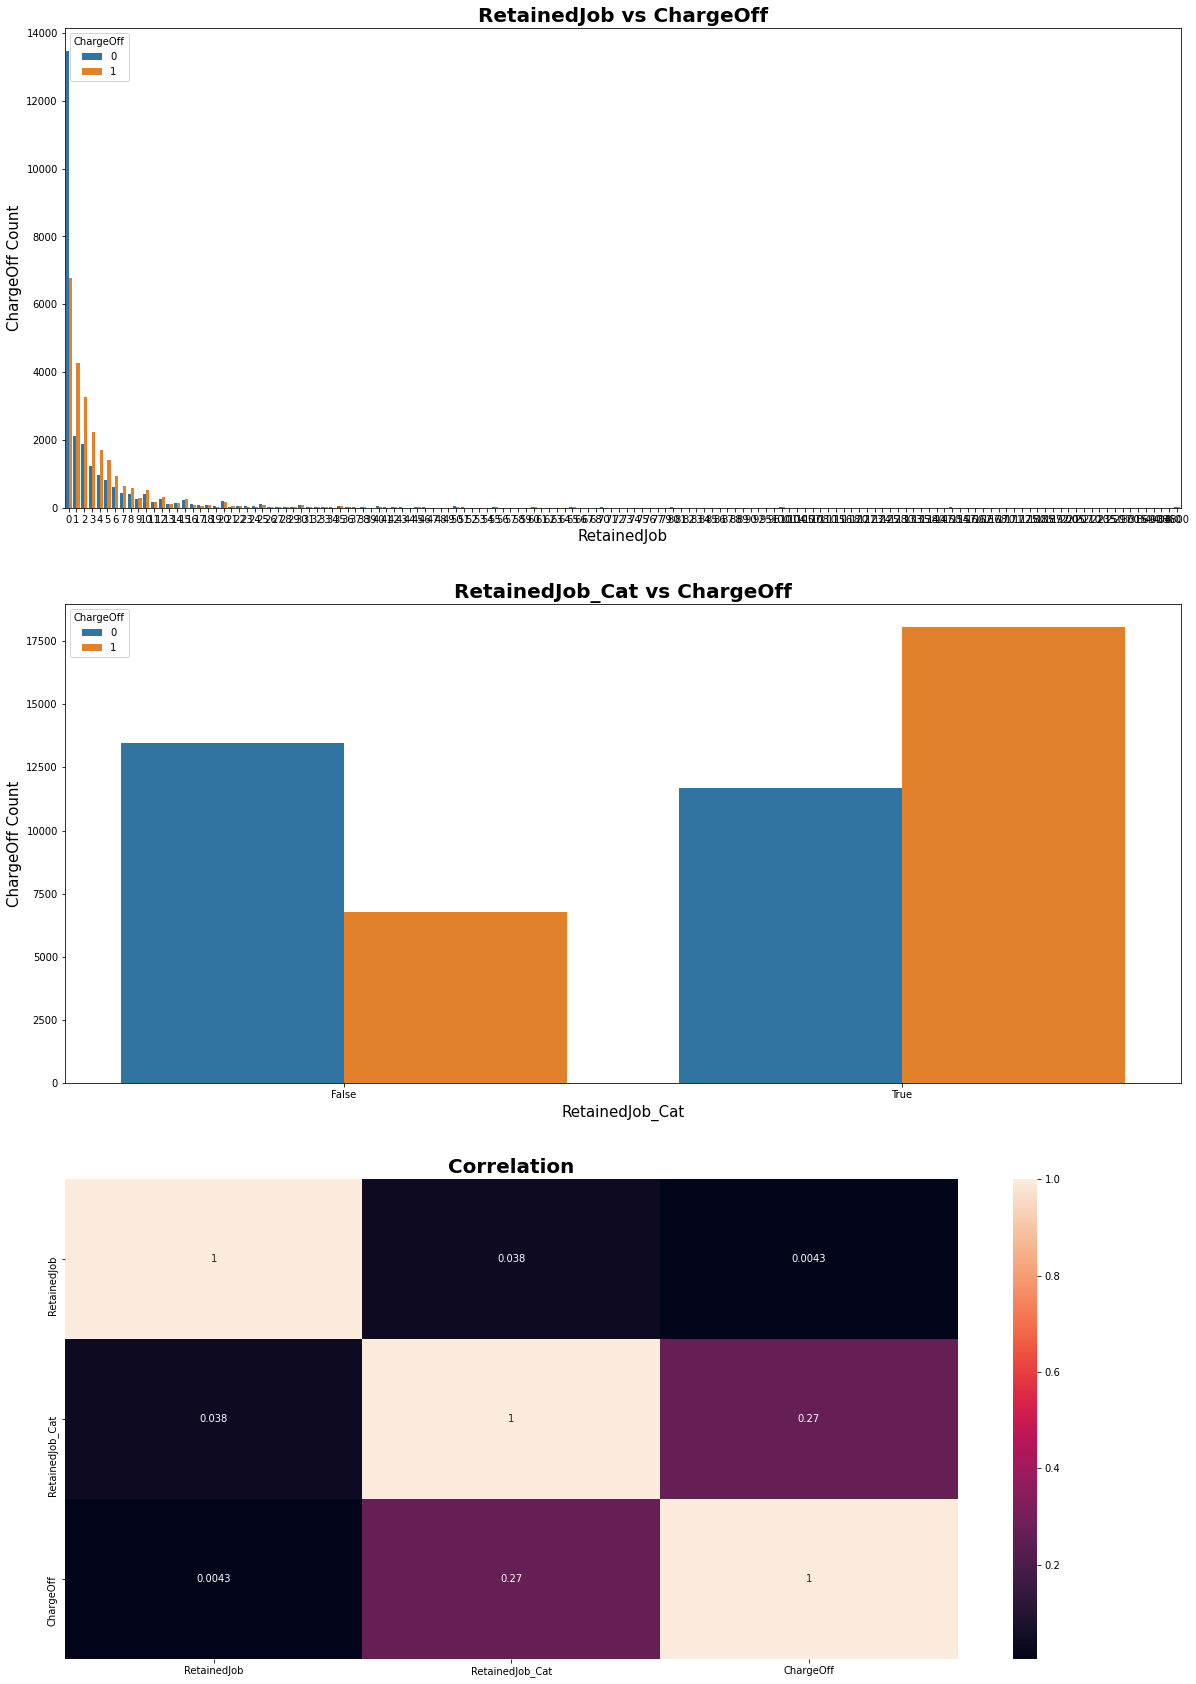

In [9]:
f, axes = plt.subplots(3, figsize=(20,30))
sb.countplot(x="RetainedJob", data = df, hue = 'ChargeOff', ax=axes[0])
df["RetainedJob_Cat"] = df["RetainedJob"].apply(lambda x: x != 0)
sb.countplot(x="RetainedJob_Cat", data = df, hue = 'ChargeOff', ax=axes[1])
sb.heatmap(df[["RetainedJob", "RetainedJob_Cat", "ChargeOff"]].corr(), annot=True, ax=axes[2])

axes[0].set_title('RetainedJob vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('RetainedJob', fontsize = 15)
axes[1].set_title('RetainedJob_Cat vs ChargeOff',fontweight="bold", size=20)
axes[1].set_ylabel('ChargeOff Count', fontsize = 15)
axes[1].set_xlabel('RetainedJob_Cat', fontsize = 15)
axes[2].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**FranchiseCode Column**  

From the information printed below, we noted the similar pattern as CreateJob, hence we can use the same approach to split the FranchiseCode column in to two categories.

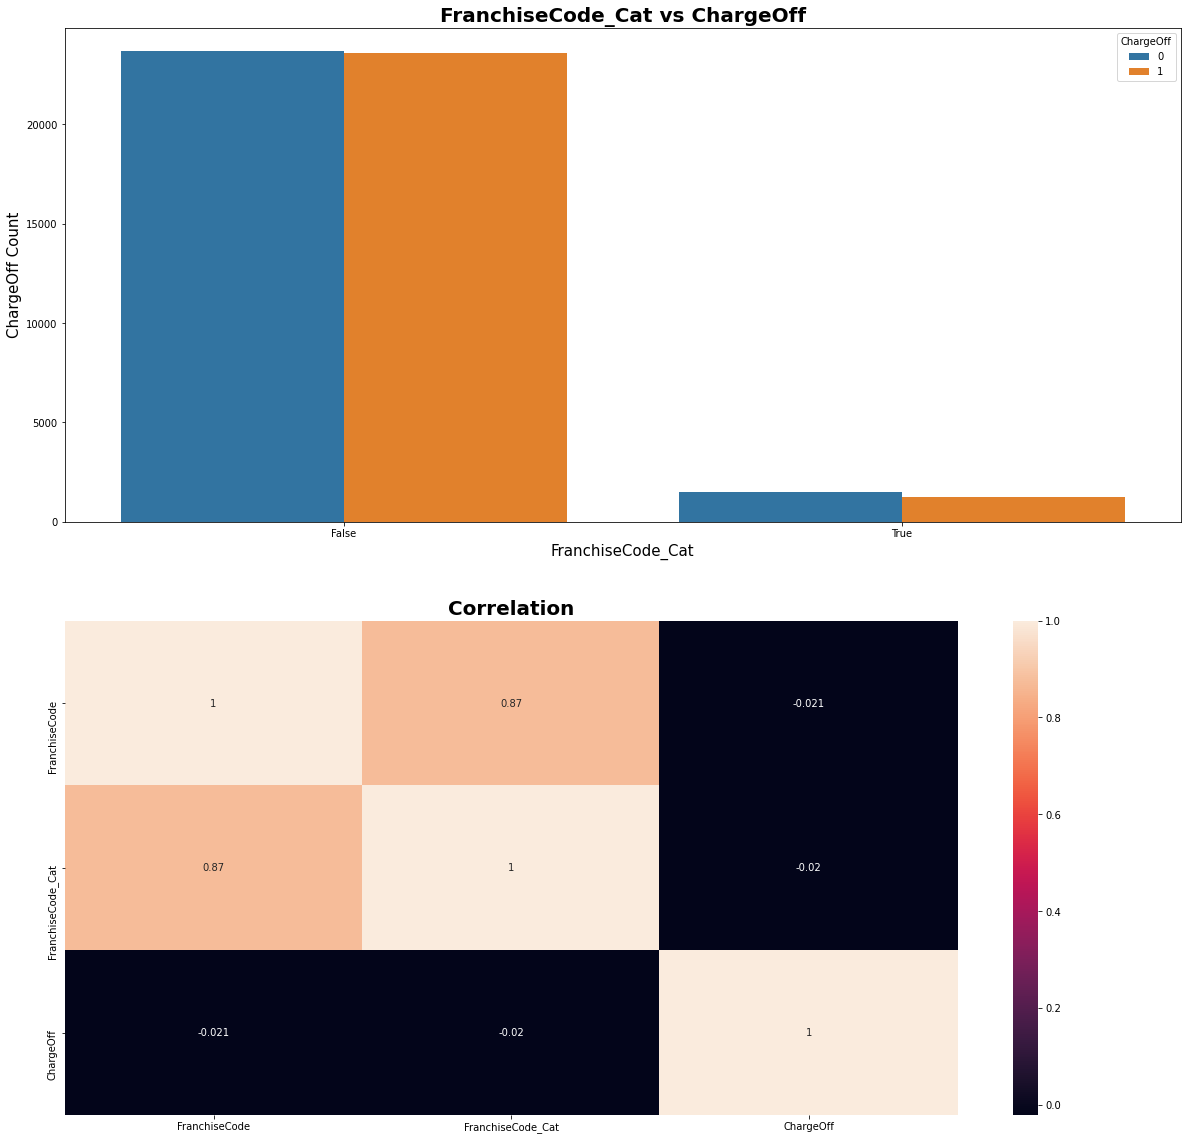

In [10]:
# if code=0 or 1 means no franchise
df["FranchiseCode_Cat"] = df["FranchiseCode"].apply(lambda x: x != 0 and x != 1)
f, axes = plt.subplots(2, figsize=(20,20))
sb.countplot(x="FranchiseCode_Cat", data = df, hue = 'ChargeOff', ax=axes[0])
sb.heatmap(df[["FranchiseCode", "FranchiseCode_Cat", "ChargeOff"]].corr(), annot=True, ax=axes[1])

axes[0].set_title('FranchiseCode_Cat vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('FranchiseCode_Cat', fontsize = 15)
axes[1].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**SBA_Appv and GrAppv Columns**  

It was noted that both columns is related to the amount granted to the company, The SBA guaranteed amount (SBA_Appv) is a part of the Gross amount (GrAppv), hence we can calculate the relationship between them.

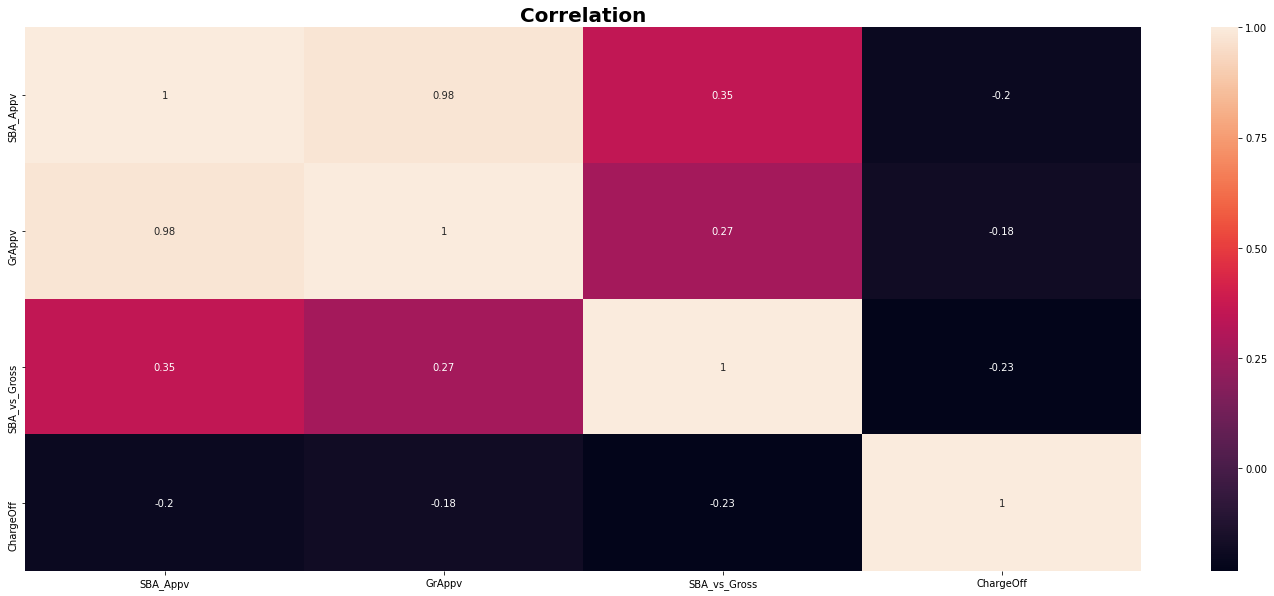

In [11]:
df['SBA_vs_Gross'] = df['SBA_Appv']/df['GrAppv']
f, ax = plt.subplots(figsize=(25,10))
sb.heatmap(df[['SBA_Appv', 'GrAppv', "SBA_vs_Gross", "ChargeOff"]].corr(), annot=True)

ax.set_title('Correlation',fontweight="bold", size=20)
plt.show()

**RealEstate Column**

During online research, we noted that for SBA loans, there a special type of loan that is backed by real estate. This kind of loan has a term of at least 20 years. Hence we can create a new feature called "RealEstate" and see it's correlation with ChargeOff.

From the plot, it was observed that if the loan is backed by real estate, the it's much more likely to be paid off. And it has a good correlation with the ChargeOff parameter.

In [12]:
df['RealEstate'] = np.where(df['Term'] >= 240, 1, 0)

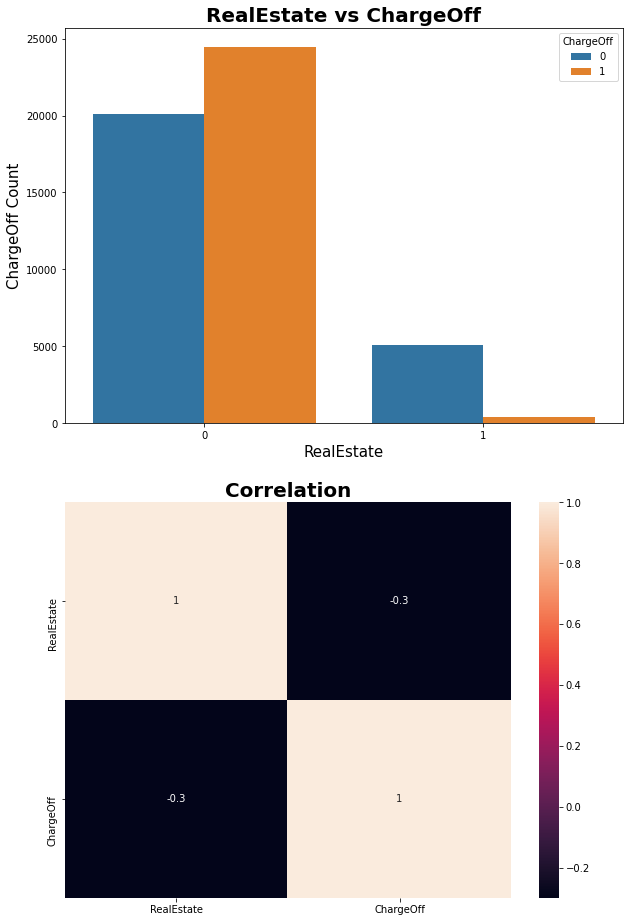

In [18]:
f, axes = plt.subplots(2, figsize=(10,16))
sb.countplot(x="RealEstate", data = df, hue = 'ChargeOff', ax=axes[0])
sb.heatmap(df[["RealEstate", "ChargeOff"]].corr(), annot=True, ax=axes[1])

axes[0].set_title('RealEstate vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('RealEstate', fontsize = 15)
axes[1].set_title('Correlation',fontweight="bold", size=20)
plt.show()

**Appv_Disbur_Same Column**

It was noted that some times the actual amount disbursed to the company is different from the amount originally approved by the bank. Usually if the amount disbursed is more than the approved amount, which is decided by the bank based on the capability of the company, it is more difficult to pay off the loan becuase you are given more than you can handle. 

From the plow below, we can see that then the disbursed amount is equal to the approved amount, it is more likely that the loan can be paid off. This feature also has a good correlation with the ChargeOff parameter.

In [13]:
df['Appv_Disbur_Same'] = np.where(df['DisbursementGross'] == df['GrAppv'], 1, 0)

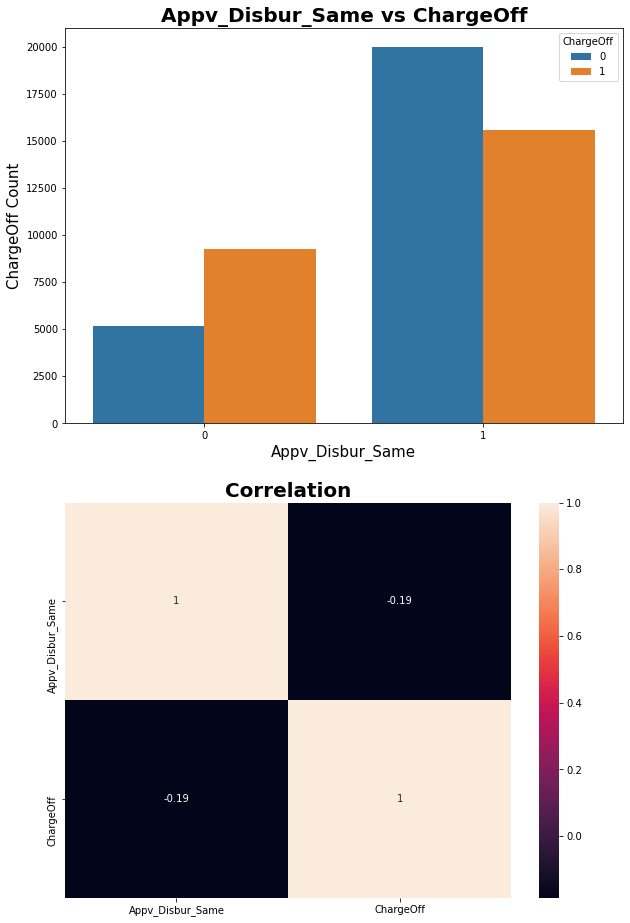

In [20]:
f, axes = plt.subplots(2, figsize=(10,16))
sb.countplot(x="Appv_Disbur_Same", data = df, hue = 'ChargeOff', ax=axes[0])
sb.heatmap(df[["Appv_Disbur_Same", "ChargeOff"]].corr(), annot=True, ax=axes[1])

axes[0].set_title('Appv_Disbur_Same vs ChargeOff',fontweight="bold", size=20)
axes[0].set_ylabel('ChargeOff Count', fontsize = 15)
axes[0].set_xlabel('Appv_Disbur_Same', fontsize = 15)
axes[1].set_title('Correlation',fontweight="bold", size=20)
plt.show()

In [14]:
df = df.drop(['State', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'DisbursementFY', 
              'CreateJob', "RetainedJob", "FranchiseCode"], axis= 1)
df.head()

,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,Def_Rate_Industry,Bank_Same_State,Def_Rate_State,GreatRecession,CreateJob_Cat,RetainedJob_Cat,FranchiseCode_Cat,SBA_vs_Gross,RealEstate,Appv_Disbur_Same
0,0,0,2010,130,25,0.0,1,0.0,0.0,2000000.0,...,0.57,0,0.36,0,True,False,False,0.75,0,1
1,1,1,2010,33,6,0.0,1,0.0,0.0,17000.0,...,0.42,1,0.48,0,True,True,False,1.00,0,1
2,2,2,2002,60,1,0.0,1,1.0,0.0,17000.0,...,0.46,0,0.49,1,True,True,False,0.50,0,1
3,3,3,1994,160,1,1.0,0,0.0,0.0,137000.0,...,0.70,1,0.60,1,False,False,False,0.90,0,1
4,4,4,2006,101,2,0.0,1,0.0,0.0,46665.0,...,0.65,1,0.54,1,True,True,False,0.50,0,0


## Part 2: Feature Selection

### Correlation between the parameters in the dataset

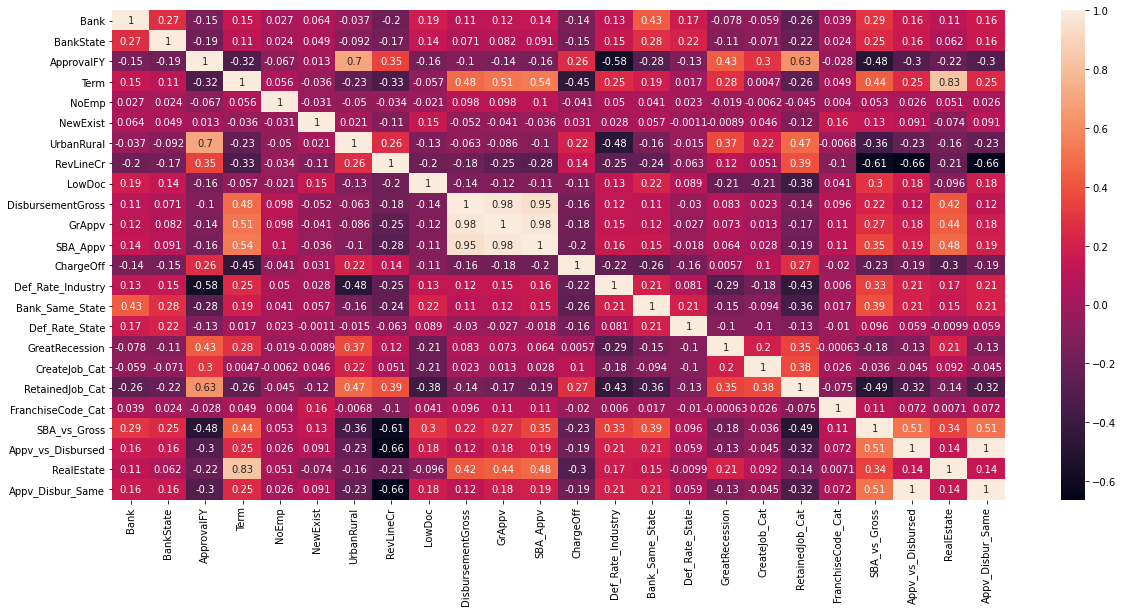

In [22]:
plt.subplots(figsize = (20,9))
sb.heatmap(df.corr(), annot=True)
plt.show()

### Feature Importance

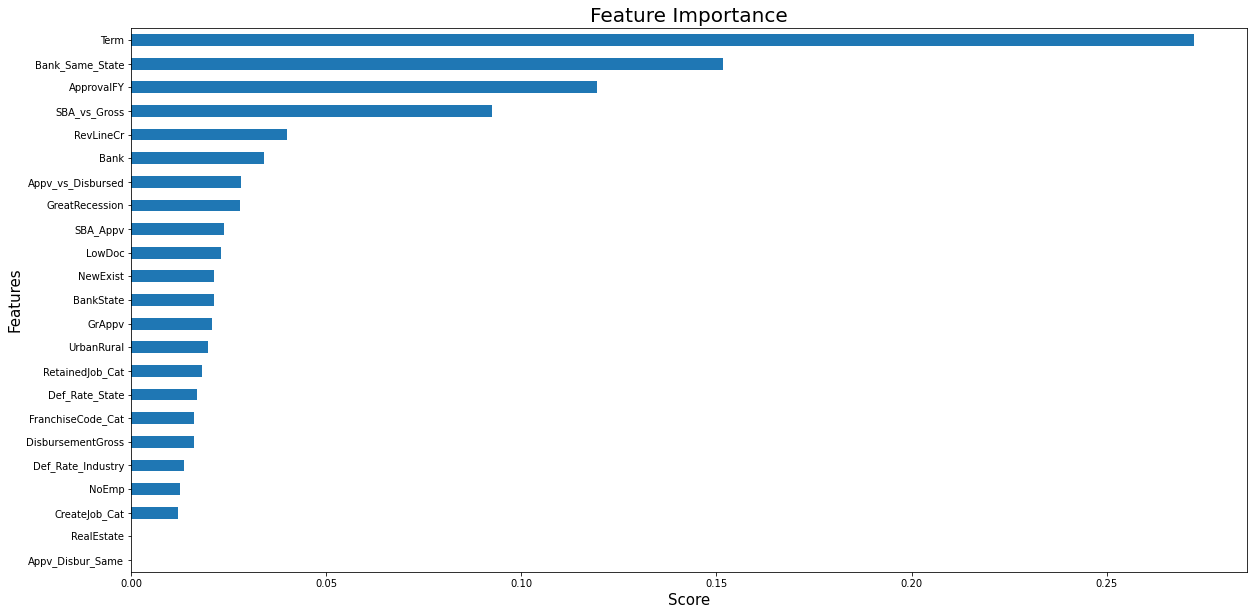

In [23]:
model = XGBClassifier()
y = df['ChargeOff']
x = df.drop(columns=['ChargeOff'], axis=1)

model.fit(x,y)
feat_importances = pd.Series(model.feature_importances_, index = x.columns)
f, ax = plt.subplots(figsize = (20,10))

feat_importances.sort_values().plot(kind = 'barh')

plt.title('Feature Importance', fontsize = 20)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Score', fontsize = 15)

plt.show()

## Part 3: Modelling

In [39]:
def train(model, df):
    y = df["ChargeOff"]
    x = df.drop(['ChargeOff'], axis= 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    print(classification_report(y_test, predict, digits=3))
    print("AUC: {}".format(roc_auc_score(y_test, predict)))

    
def pipeline(model, df):
    y = df["ChargeOff"]
    x = df.drop(['ChargeOff'], axis= 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)
    pipe = Pipeline(steps=[('feature_selection', SelectKBest(chi2, k="all")), ('model', model)])
    pipe.fit(x_train, y_train)
    predict = pipe.predict(x_test)

    print(classification_report(y_test, predict, digits=3))
    
    for name, importance in sorted(zip(x.columns, model.feature_importances_)):
        print(name, "=", importance)

### Model Selection  

**1. Test the performance using the XGBClassifier with default parameters**

In [40]:
df_train = df.copy()
train(XGBClassifier(), df)

              precision    recall  f1-score   support

           0      0.940     0.937     0.938      2574
           1      0.933     0.937     0.935      2426

    accuracy                          0.937      5000
   macro avg      0.937     0.937     0.937      5000
weighted avg      0.937     0.937     0.937      5000

AUC: 0.9365977294666494


**2. Use Pipeline to select k best features**

Noted that the best result is achieved using all the features.

In [41]:
df_pipeline = df.copy()
pipeline(XGBClassifier(), df_train)

              precision    recall  f1-score   support

           0      0.940     0.937     0.938      2574
           1      0.933     0.937     0.935      2426

    accuracy                          0.937      5000
   macro avg      0.937     0.937     0.937      5000
weighted avg      0.937     0.937     0.937      5000

ApprovalFY = 0.13011354
Appv_Disbur_Same = 0.0
Appv_vs_Disbursed = 0.03622292
Bank = 0.03645549
BankState = 0.022897184
Bank_Same_State = 0.11694354
CreateJob_Cat = 0.015023926
Def_Rate_Industry = 0.015223686
Def_Rate_State = 0.017409535
DisbursementGross = 0.01748789
FranchiseCode_Cat = 0.01595476
GrAppv = 0.024733888
GreatRecession = 0.015453971
LowDoc = 0.025211386
NewExist = 0.021157907
NoEmp = 0.01351856
RealEstate = 0.0
RetainedJob_Cat = 0.01303439
RevLineCr = 0.04073025
SBA_Appv = 0.024030745
SBA_vs_Gross = 0.085323356
Term = 0.28883764
UrbanRural = 0.024235476


**3. Compare with other types of models**

In [44]:
print("Logistic Regression Classifier: ")
df_train = df.copy()
train(LogisticRegression(), df_train)

Logistic Regression Classifier: 
              precision    recall  f1-score   support

           0      0.817     0.710     0.760      2574
           1      0.730     0.831     0.777      2426

    accuracy                          0.769      5000
   macro avg      0.774     0.771     0.769      5000
weighted avg      0.775     0.769     0.768      5000

AUC: 0.7707942190629744


In [45]:
print("Gaussian Naive Bayes Classifier: ")
df_train = df.copy()
train(GaussianNB(), df_train)

Gaussian Naive Bayes Classifier: 
              precision    recall  f1-score   support

           0      0.751     0.373     0.499      2574
           1      0.566     0.869     0.686      2426

    accuracy                          0.614      5000
   macro avg      0.659     0.621     0.592      5000
weighted avg      0.661     0.614     0.589      5000

AUC: 0.6209283525854012


In [46]:
print("K-Neighbors Classifier: ")
df_train = df.copy()
train(KNeighborsClassifier(), df_train)

K-Neighbors Classifier: 
              precision    recall  f1-score   support

           0      0.722     0.697     0.709      2574
           1      0.690     0.716     0.703      2426

    accuracy                          0.706      5000
   macro avg      0.706     0.706     0.706      5000
weighted avg      0.707     0.706     0.706      5000

AUC: 0.7062754502985337


In [47]:
print("Random Forest Classifier: ")
df_train = df.copy()
train(RandomForestClassifier(), df_train)

Random Forest Classifier: 
              precision    recall  f1-score   support

           0      0.903     0.926     0.914      2574
           1      0.919     0.895     0.907      2426

    accuracy                          0.911      5000
   macro avg      0.911     0.910     0.911      5000
weighted avg      0.911     0.911     0.911      5000

AUC: 0.9103425657424008


### Model Tuning

In [15]:
def find_optimal_parameters(clf, params,x_train,y_train, x_test, y_test):
    
    search = GridSearchCV(estimator=clf,
                          param_grid=params,
                          scoring = 'f1',
                          n_jobs = -1,
                          cv = 3,
                          verbose=True)

    
    search.fit(x_train, y_train)
    model = search.best_estimator_.fit(x_train, y_train)
    print('Best parameters: \n',search.best_params_)
    print('='*70)
          
    y_test_ypred = model.predict(x_test)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    return model

df_train = df.copy()
y = df_train["ChargeOff"]
x = df_train.drop(['ChargeOff'], axis= 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)
model = XGBClassifier()

#find best learning_rate and n_estimator first
params ={"learning_rate"    : [0.05, 0.1, 0.15],
         "n_estimators"     : [ 150, 200, 250, 300]}
model = find_optimal_parameters(model, params, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: 
 {'learning_rate': 0.15, 'n_estimators': 300}
Classification Report: 
               precision    recall  f1-score   support

           0      0.939     0.925     0.932      2574
           1      0.921     0.936     0.929      2426

    accuracy                          0.930      5000
   macro avg      0.930     0.930     0.930      5000
weighted avg      0.930     0.930     0.930      5000



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   32.0s finished


In [16]:
#find best combination for other parameters
params ={"max_depth"        : [ 6, 7, 8, 9],
         "min_child_weight" : [ 1, 3, 5, 7 ],
         "gamma"            : [ 0.0, 0.1, 0.2 ],
         "colsample_bytree" : [ 0.3, 0.4, 0.5]}
model = XGBClassifier(learning_rate = '0.15', n_estimators = 300)
model = find_optimal_parameters(model, params, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: 
 {'colsample_bytree': 0.5, 'gamma': 0.2, 'max_depth': 6, 'min_child_weight': 1}
Classification Report: 
               precision    recall  f1-score   support

           0      0.942     0.934     0.938      2574
           1      0.931     0.939     0.935      2426

    accuracy                          0.936      5000
   macro avg      0.936     0.936     0.936      5000
weighted avg      0.936     0.936     0.936      5000



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  8.5min finished


In [17]:
#train learning_rate and n_estimator again
params ={"learning_rate"    : [0.1, 0.15, 0.2],
         "n_estimators"     : [ 300, 350, 400, 450, 500]}

model = XGBClassifier(max_depth = 6, min_child_weight = 1, gamma = 0.2, colsample_bytree = 0.5)
model = find_optimal_parameters(model, params, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters: 
 {'learning_rate': 0.15, 'n_estimators': 400}
Classification Report: 
               precision    recall  f1-score   support

           0      0.943     0.934     0.939      2574
           1      0.931     0.940     0.935      2426

    accuracy                          0.937      5000
   macro avg      0.937     0.937     0.937      5000
weighted avg      0.937     0.937     0.937      5000



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished
